# Predict the usage of gas

## 1. Import packages and data and create the dataframe

### 1.1 Packages/logger

In [8]:
import pandas as pd
import numpy as np
import datetime as dt
import plotnine as p9
import logging
import matplotlib.pyplot as plt
#from plotnine import *
#from plotnine.data import *

%matplotlib inline

In [9]:
from functools import wraps 

def log_step(func): 
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        shape_before = args[0].shape
        shape_after = result.shape
        print(f"{func.__name__} => before shape:{shape_before} after shape:{shape_after}")
        return result
    return wrapper

logging.getLogger().setLevel(logging.DEBUG)


### 1.2 Import data

In [10]:
df_energy = pd.read_csv('c://users//iwan//documents/github//private//kerk//data//dataset.csv')
df_wheater = df = pd.read_csv("//raspberrypi/pi/domoticz/data/logging.csv")

In [11]:
df_month = pd.DataFrame([["(01) Jan", 1], ["(02) Feb", 2], ["(03) Mar", 3], ["(04) Apr", 4], 
                         ["(05) May", 5], ["(06) Jun", 6], ["(07) Jul", 7], ["(08) Aug", 8], 
                         ["(09) Sep", 9], ["(10) Oct", 10], ["(11) Nov", 11], ["(12) Dec", 12]], 
                        columns=["month", "number"])

month = dict(zip(df_month.number, df_month.month))

df_day = pd.DataFrame([["(0) Sunday", 0] , ["(1) Monday", 1], ["(2) Tuesday", 2], ["(3) Wednesday", 3],
                       ["(4) Thursday", 4], ["(5) Friday", 5], ["(6) Saturday", 6]],
                      columns=["day", "number"])

day = dict(zip(df_day.number, df_day.day))

### 1.3 Create dataframe

In [17]:
@log_step 
def start_pipeline(dataf):
    return dataf

@log_step
def create_date_gas(dataf):
    return dataf.assign(datetime=lambda d: pd.to_datetime(d['datetime'], format="%d-%m-%Y"),
                        date=lambda d: pd.to_datetime(d['datetime'].dt.date))

@log_step
def remove_datetime(dataf):
    return dataf.drop(columns=['datetime'])

@log_step
def create_df_gas(dataf):
    dataf = (
        dataf[['date', 'type', 'quantity']]
        .loc[lambda d: d['type'] =="gas"]
        .reset_index()
        .assign(gas_usage=lambda d: d['quantity']-d['quantity'].shift(1))
        .rename(columns={"quantity": "meter_reading"})
        .drop(columns=['index', 'type'])
    )
    return dataf

@log_step
def create_date_temp(dataf):
    return (dataf
            .assign(datetime=lambda d: pd.to_datetime(d['Timestamp'], format="%d-%m-%Y  %H:%M:%S"))
            .drop(columns=['Timestamp'])
           )


@log_step
def select_columns_temp(dataf):
    dataf = df_wheater[['Timestamp', 'Buitentemperatuur']]
    return dataf
            
@log_step
def create_time_temp(dataf):
    return dataf.assign(time = [dt.datetime.time(d) for d in dataf['datetime']])


@log_step
def calculate_temperature_values(dataf):
    return (
        dataf
        .assign(date=lambda d: pd.to_datetime(d['datetime'].dt.date))
        .assign(temp_mean=lambda d: d.groupby('date')['Buitentemperatuur'].transform(np.mean),
                temp_max=lambda d: d.groupby('date')['Buitentemperatuur'].transform(np.max),
                temp_min=lambda d: d.groupby('date')['Buitentemperatuur'].transform(np.min)
               )
        .drop(columns=['date', 'Buitentemperatuur'])
    )

@log_step
def selected_day_temp(dataf):
    return (
        dataf
        .set_index('datetime')
        .between_time('00:00:00', '00:00:01')
        .reset_index()
        .rename(columns={"datetime": "date"})
    )

@log_step
def date_to_index(dataf):
    return dataf.set_index('date')

# Create dataframe gas usage
df_gas = (
    df_energy
    .pipe(start_pipeline)
    .pipe(create_date_gas)
    .pipe(remove_datetime)
    .pipe(create_df_gas)
    .pipe(date_to_index)
)

# Create dataframe gas usage and temperature
df_gas_temp = (
    df_gas
    .join(
        df_wheater
        .pipe(start_pipeline)
        .pipe(select_columns_temp)
        .pipe(create_date_temp)
        .pipe(calculate_temperature_values)
        .pipe(selected_day_temp)
        .pipe(date_to_index)
    )
    .dropna()
    .loc[lambda d: d['gas_usage'] <= 60]  # Remove highest value
)


start_pipeline => before shape:(1531, 6) after shape:(1531, 6)
create_date_gas => before shape:(1531, 6) after shape:(1531, 7)
remove_datetime => before shape:(1531, 7) after shape:(1531, 6)
create_df_gas => before shape:(1531, 6) after shape:(307, 3)
date_to_index => before shape:(307, 3) after shape:(307, 2)
start_pipeline => before shape:(415553, 28) after shape:(415553, 28)
select_columns_temp => before shape:(415553, 28) after shape:(415553, 2)
create_date_temp => before shape:(415553, 2) after shape:(415553, 2)
calculate_temperature_values => before shape:(415553, 2) after shape:(415553, 4)
selected_day_temp => before shape:(415553, 4) after shape:(252, 4)
date_to_index => before shape:(252, 4) after shape:(252, 3)


# 2 Investigation

### 2.1 Usage of gas daily based

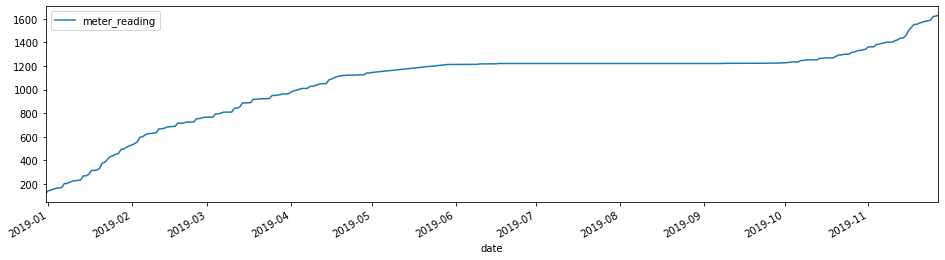

In [20]:
df_gas[['meter_reading']].plot(figsize=(16, 4))

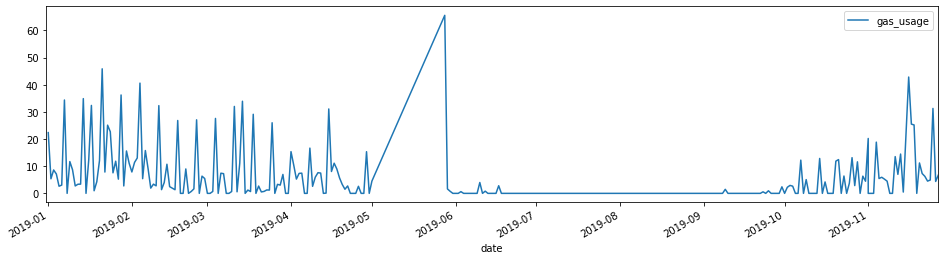

In [21]:
df_gas[['gas_usage']].plot(figsize=(16, 4))

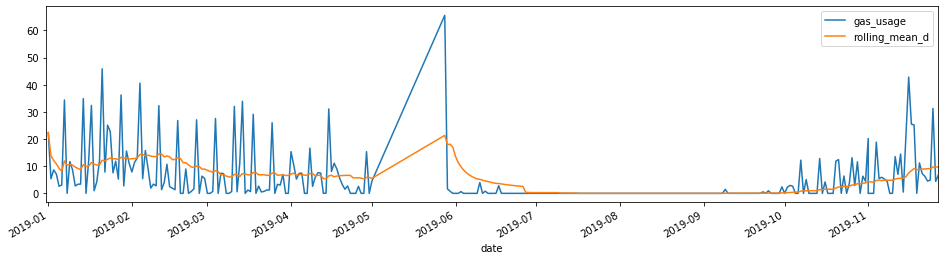

In [22]:
(
    df_gas[['gas_usage']]
    .assign(rolling_mean_d=lambda d: d['gas_usage']
            .rolling("30D")
            .mean()
           )
    .plot(figsize=(16,4))
)

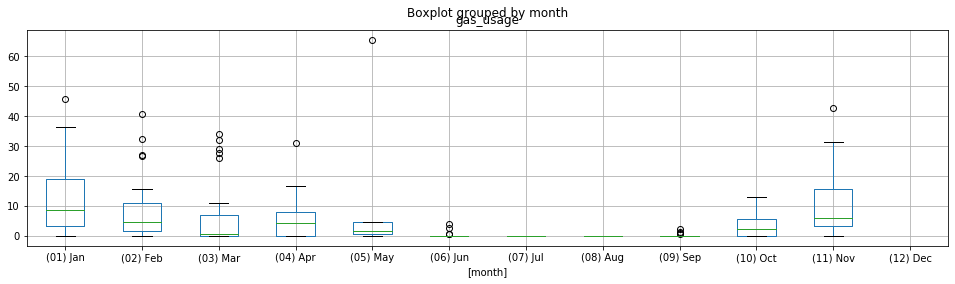

In [23]:
(
    df_gas[['gas_usage']]
    .reset_index()
    .assign(month=lambda d: d['date'].dt.month.map(month))
    .drop(['date'], axis=1)
    .set_index('month')
    .boxplot(by=['month'], figsize=(16,4))
)

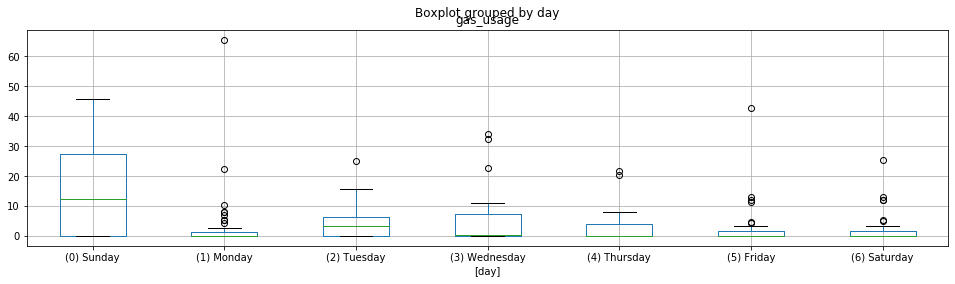

In [24]:
(
    df_gas[['gas_usage']]
    .reset_index()
    .assign(day=lambda d: d['date'].dt.weekday.map(day))
    .drop(['date'], axis=1)
    .set_index('day')
    .boxplot(by=['day'], figsize=(16,4))
)

Conclusions: 
- Data is missing in May 2019
- The gas usage in the summerperiod is normal.

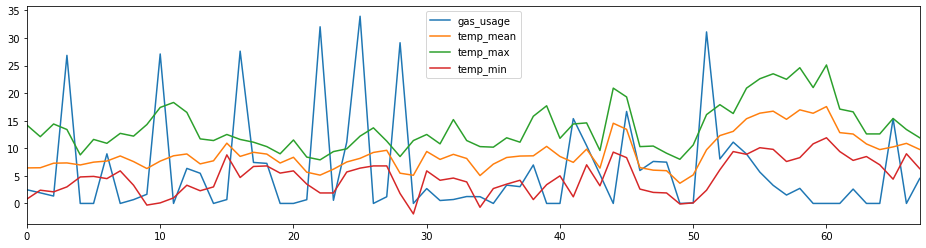

In [255]:
df_winter_2019 = df.reset_index().loc[lambda d: d['date'] <= '2019-05-01']
df_winter_2019[['gas_usage','temp_mean', 'temp_max', 'temp_min']].plot(figsize=(16, 4))

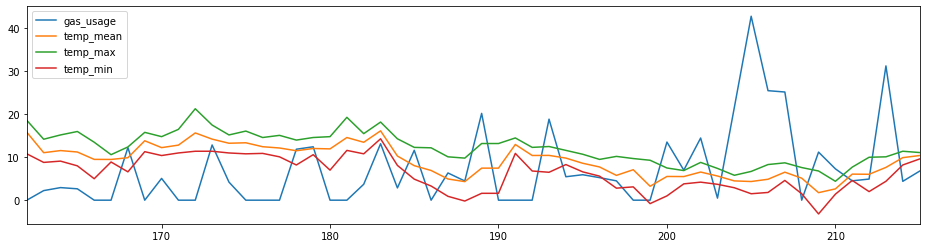

In [254]:
df_fall_2019 = df.reset_index().loc[lambda d: d['date'] >= '2019-10-01']
df_fall_2019[['gas_usage','temp_mean', 'temp_max', 'temp_min']].plot(figsize=(16, 4))

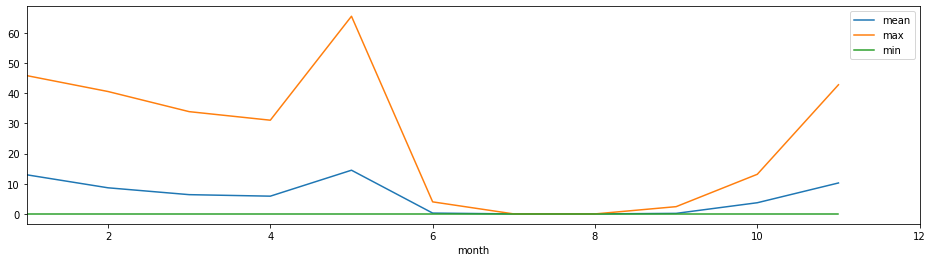

In [28]:
mean=(
    df_gas
    .reset_index()
    .assign(month=lambda d: d['date'].dt.month)
    .groupby('month')
    .apply(lambda d: pd.Series({"mean": np.mean(d['gas_usage'])}))
)

maximum=(
    df_gas
    .reset_index()
    .assign(month=lambda d: d['date'].dt.month)
    .groupby('month')
    .apply(lambda d: pd.Series({"max": np.max(d['gas_usage'])}))
)

minimal=(
    df_gas
    .reset_index()
    .assign(month=lambda d: d['date'].dt.month)
    .groupby('month')
    .apply(lambda d: pd.Series({"min": np.min(d['gas_usage'])}))
)

(
   mean
    .join(maximum)
    .join(minimal)
    .plot(figsize=(16, 4))
)

del mean
del maximum
del minimal